In [1]:
import sys
import os
current_dir = os.getcwd()  
project_root = os.path.dirname(current_dir)  
sys.path.insert(0, project_root) 
from pathlib import Path
import warnings
import pandas as pd
from pycaret.regression import *
from src.config.config import Config
from src.data.data_loader import DataLoader
from src.models.model_evaluator import ModelEvaluator
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor

def train_models(train: pd.DataFrame,val: pd.DataFrame,target_column: str):
    """训练模型流程
    Args:
        data_path: 可选的数据文件路径
    """
    model_evaluator.setup_experiment(
        train_size=Config.MODEL_CONFIG['train_size'],
        train_data=train,
        val_data = val,
        target_column = target_column,
        categorical_features = Config.FEATURE_CONFIG['categorical_columns']
    )

    # 训练模型并返回最佳模型字典
    return model_evaluator.train_top_models(n_models=Config.MODEL_CONFIG['n_top_models'])

def tune(models: dict):
    """模型调优和集成"""
    # 对top模型进行调优
    tuned_models = model_evaluator.tune_models(models)

    return tuned_models

def ensemble(models: dict):
    """模型集成"""
    # 对top模型进行集成
    blended_model = model_evaluator.ensemble_models(models)

    return blended_model    
    # 模型
    
def save_models(models: dict):

    model_evaluator.saved_models(models)

def select_features(train_data: pd.DataFrame, test_data: pd.DataFrame, 
                   time_test_data: pd.DataFrame, n_features: int = 5) -> tuple:
    """选择最重要的特征
    
    Args:
        train_data: 训练数据
        test_data: 测试数据
        time_test_data: 时间测试数据
        n_features: 要选择的特征数量
        
    Returns:
        tuple: (处理后的训练集, 测试集, 时间测试集)
    """
    # 排除不需要的列
    feature_cols = [col for col in train_data.columns 
                    if col not in [Config.DATA_CONFIG['target_column'], 
                                 'Country Name', 'Year', 'Region', 'Income Group']]
    
    # 准备数据
    X = train_data[feature_cols]
    y = train_data[f"{Config.DATA_CONFIG['target_column']}_{Config.FEATURE_CONFIG['target_transform_method']}"]
    
    # 使用F-regression进行特征选择
    selector = SelectKBest(score_func=f_regression, k=n_features)
    selector.fit(X, y)
    
    # 获取选中的特征，排除目标变量
    target_transformed = f"{Config.DATA_CONFIG['target_column']}_{Config.FEATURE_CONFIG['target_transform_method']}"
    selected_features = pd.DataFrame({
        'feature': feature_cols,
        'score': selector.scores_
    }).sort_values('score', ascending=False).head(n_features)['feature'].tolist()
    
    print(f"\n选择的{n_features}个特征:")
    for i, feature in enumerate(selected_features, 1):
        print(f"{i}. {feature}")
    
    # 更新数据集，保留目标变量和转换后的目标变量
    selected_columns = selected_features + [target_transformed]
    train = train_data[selected_columns]
    test = test_data[selected_columns]
    time_test = time_test_data[selected_columns]
    
    return train, test, time_test

In [2]:
# 示例用法
df = pd.read_csv(Path(Config.PATH_CONFIG['features_dir'])  / 'training_data.csv')
data_loader = DataLoader()
model_evaluator = ModelEvaluator()

# 划分数据集
train_data, val_data, country_test_data = data_loader.split_data_by_countries(
    df,
    train_size=Config.DATA_CONFIG['country_train_size'],
    val_size=Config.DATA_CONFIG['country_val_size'],
    random_state=Config.DATA_CONFIG['random_state']
)

train_data, time_test_data = data_loader.split_data_by_time(train_data,
    test_size=Config.DATA_CONFIG['time_test_size'])

# 数据分析
print('\n训练集统计信息:')
data_loader.analyze_datasets(train_data)
print('\n验证集统计信息:')
data_loader.analyze_datasets(val_data)
print('\n外部国家测试集统计信息:')
data_loader.analyze_datasets(country_test_data)
print('\n外部时间测试集统计信息:')
data_loader.analyze_datasets(time_test_data)
#合并验证集和外部国家测试集作为测试集
test_data = pd.concat([val_data, country_test_data])
print('\n合并，作为测试集统计信息:')
data_loader.analyze_datasets(test_data)


训练集统计信息:
总数据条数: 251
国家总数: 32
包含的国家: Austria, Belgium, Bulgaria, China, Croatia, Cyprus, Denmark, Estonia, France, Greece, Hungary, Iceland, Ireland, Italy, Latvia, Lithuania, Luxembourg, Malta, Montenegro, Netherlands, North Macedonia, Norway, Poland, Portugal, Romania, Serbia, Slovak Republic, Spain, Sweden, Turkiye, United Kingdom, United States

特征数量: 54
特征列表: HIW, HIW_log, IW, development_population_impact, economic_density, gdp_population_interaction, gdp_ppp_2017_cubic, gdp_ppp_2017_growth, gdp_ppp_2017_log, gdp_ppp_2017_ma_3, gdp_ppp_2017_ma_5, gdp_ppp_2017_ma_7, gdp_ppp_2017_rel_change_3, gdp_ppp_2017_rel_change_5, gdp_ppp_2017_rel_change_7, gdp_ppp_2017_squared, gdp_ppp_2017_trend, gdp_ppp_2017_trend_deviation, gdp_ppp_2017_trend_strength_3, gdp_ppp_2017_trend_strength_5, gdp_ppp_2017_trend_strength_7, gdp_ppp_per_capita_2017_cubic, gdp_ppp_per_capita_2017_growth, gdp_ppp_per_capita_2017_log, gdp_ppp_per_capita_2017_ma_3, gdp_ppp_per_capita_2017_ma_5, gdp_ppp_per_capita_2017_

In [3]:
train_data.to_csv(os.path.join(Config.PATH_CONFIG['data_dir'], 'train.csv'), index=False)
test_data.to_csv(os.path.join(Config.PATH_CONFIG['data_dir'], 'test.csv'), index=False)
time_test_data.to_csv(os.path.join(Config.PATH_CONFIG['data_dir'], 'time_test_data.csv'), index=False)

# 排除不需要的列
feature_cols = [col for col in train_data.columns 
                if col not in [Config.DATA_CONFIG['target_column'], 'Country Name', 'Year','Region', 'Income Group']]

train = train_data[feature_cols]
test = test_data[feature_cols]
time_test_data = time_test_data[feature_cols] 

target_column = Config.DATA_CONFIG['target_column']
method = Config.FEATURE_CONFIG['target_transform_method']
transformed_column = f'{target_column}_{method}'

# 使用方法
train, test, time_test_data = select_features(train_data, test_data, time_test_data,n_features=8 )



选择的8个特征:
1. gdp_ppp_2017_log
2. gdp_ppp_2017_squared
3. gdp_ppp_2017_cubic
4. population_log
5. population_squared
6. gdp_population_interaction
7. population_cubic
8. economic_density


In [4]:
# 训练模型
models = train_models(train,test,transformed_column)

,Description,Value
0,Session id,888
1,Target,HIW_log
2,Target type,Regression
3,Original data shape,"(310, 9)"
4,Transformed data shape,"(310, 9)"
5,Transformed train set shape,"(251, 9)"
6,Transformed test set shape,"(59, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9642,1.8216,1.2616,0.2641,0.0860,0.0699,0.0500
catboost,CatBoost Regressor,1.0044,2.1909,1.3551,0.1266,0.0932,0.0736,0.2780
ada,AdaBoost Regressor,0.9992,2.2725,1.3816,0.1408,0.0945,0.0727,0.0140
gbr,Gradient Boosting Regressor,1.0268,2.1974,1.3878,0.1905,0.0949,0.0751,0.0160
ridge,Ridge Regression,1.0541,2.0800,1.3989,0.2410,0.0967,0.0763,0.4120
br,Bayesian Ridge,1.1162,2.2357,1.4448,0.1680,0.1000,0.0805,0.0060
rf,Random Forest Regressor,1.0534,2.6290,1.4459,0.0693,0.0983,0.0778,0.0300
et,Extra Trees Regressor,1.0223,2.4823,1.4549,0.0851,0.1003,0.0759,0.0260
omp,Orthogonal Matching Pursuit,1.1949,2.3247,1.4708,0.1858,0.1010,0.0862,0.3420
lightgbm,Light Gradient Boosting Machine,1.1430,2.6139,1.4798,-0.1287,0.1026,0.0833,0.0340


In [5]:
# 定义需要包含的模型简称集合
include_models = {'rf','xgboost','et','lightgbm','gbr','catboost'}

# 生成过滤后的有序字典
model_dict = {
    k: v for k, v in models.items()
    if k in include_models
}

In [6]:
print(f'当前调优模型: {", ".join(model_dict.keys())}')

# 调优
tune_models = tune(model_dict)

当前调优模型: xgboost, catboost, gbr, rf, et, lightgbm
当前调优模型: xgboost , 结果如下:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8188,1.3602,1.1663,0.3932,0.0730,0.0534
1,1.6312,4.0139,2.0035,-1.2628,0.1308,0.1123
2,0.6749,0.8005,0.8947,0.7959,0.0641,0.0504
3,1.0030,1.8533,1.3614,0.6041,0.0994,0.0785
4,0.6121,0.6001,0.7746,0.9074,0.0540,0.0448
Mean,0.9480,1.7256,1.2401,0.2876,0.0843,0.0679
Std,0.3671,1.2255,0.4333,0.7947,0.0277,0.0251


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,1.1177,1.7783,1.3335,0.5218,0.0908,0.0823


当前调优模型: catboost , 结果如下:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7977,1.3461,1.1602,0.3995,0.0724,0.0516
1,1.7402,4.5393,2.1306,-1.5590,0.1402,0.1193
2,0.6351,0.5575,0.7467,0.8579,0.0516,0.0466
3,1.2351,3.1970,1.7880,0.3171,0.1325,0.1020
4,0.5118,0.6403,0.8002,0.9012,0.0582,0.0390
Mean,0.9840,2.0560,1.3251,0.1833,0.0910,0.0717
Std,0.4504,1.5635,0.5478,0.9023,0.0377,0.0325


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,1.1687,2.2658,1.5053,0.3908,0.1035,0.0873


当前调优模型: gbr , 结果如下:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8581,1.5284,1.2363,0.3181,0.0779,0.0562
1,1.6473,4.0532,2.0133,-1.2849,0.1321,0.1129
2,0.5381,0.4141,0.6435,0.8945,0.0431,0.0392
3,1.2728,3.9708,1.9927,0.1518,0.1469,0.1076
4,0.5102,0.4157,0.6448,0.9359,0.0468,0.0380
Mean,0.9653,2.0765,1.3061,0.2031,0.0893,0.0708
Std,0.4384,1.6321,0.6087,0.8056,0.0429,0.0329


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.1075,2.0725,1.4396,0.4427,0.1012,0.0832


当前调优模型: rf , 结果如下:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7516,0.8924,0.9447,0.6019,0.0590,0.0502
1,1.7254,4.3352,2.0821,-1.4439,0.1373,0.1173
2,0.7856,0.9254,0.9620,0.7641,0.0718,0.0607
3,1.0986,1.7711,1.3308,0.6217,0.0973,0.0854
4,1.1183,1.6422,1.2815,0.7466,0.0812,0.0755
Mean,1.0959,1.9133,1.3202,0.2581,0.0893,0.0778
Std,0.3498,1.2631,0.4127,0.8535,0.0271,0.0231


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.9826,1.8035,1.3429,0.5151,0.0964,0.0755


当前调优模型: et , 结果如下:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9988,2.1833,1.4776,0.0260,0.0942,0.0647
1,1.6038,4.0085,2.0021,-1.2598,0.1317,0.1096
2,0.4744,0.3190,0.5648,0.9187,0.0390,0.0349
3,1.2409,3.8652,1.9660,0.1744,0.1458,0.1059
4,0.8545,1.5427,1.2421,0.7620,0.0913,0.0692
Mean,1.0345,2.3838,1.4505,0.1242,0.1004,0.0769
Std,0.3779,1.4032,0.5289,0.7701,0.0372,0.0279


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.0655,1.4685,1.2118,0.6051,0.0833,0.0779


当前调优模型: lightgbm , 结果如下:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5860,3.2909,1.8141,-0.4682,0.1177,0.1063
1,1.1731,2.3042,1.5179,-0.2989,0.0958,0.0765
2,0.8394,1.3087,1.1440,0.6664,0.0848,0.0649
3,1.1434,2.1076,1.4517,0.5498,0.1042,0.0880
4,0.9508,1.1612,1.0776,0.8208,0.0693,0.0656
Mean,1.1385,2.0345,1.4011,0.2540,0.0944,0.0803
Std,0.2554,0.7676,0.2674,0.5303,0.0165,0.0155


[LightGBM] [Warning] feature_fraction is set=0.47518646347933446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47518646347933446
[LightGBM] [Warning] bagging_fraction is set=0.5353322223145005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5353322223145005
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.0933,1.9687,1.4031,0.4707,0.0985,0.0822


[LightGBM] [Warning] feature_fraction is set=0.47518646347933446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47518646347933446
[LightGBM] [Warning] bagging_fraction is set=0.5353322223145005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5353322223145005
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [7]:
# 集成
models = ensemble(tune_models)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8435,1.5366,1.2396,0.3145,0.0775,0.0542
1,1.5487,3.6140,1.9010,-1.0373,0.1242,0.1053
2,0.4944,0.3500,0.5916,0.9108,0.0440,0.0378
3,1.1440,2.5534,1.5979,0.4546,0.1194,0.0931
4,0.7045,0.7525,0.8675,0.8839,0.0609,0.0517
Mean,0.9470,1.7613,1.2395,0.3053,0.0852,0.0684
Std,0.3675,1.1933,0.4742,0.7108,0.0317,0.0260


[LightGBM] [Warning] feature_fraction is set=0.47518646347933446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47518646347933446
[LightGBM] [Warning] bagging_fraction is set=0.5353322223145005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5353322223145005
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
6,Voting Regressor,0.9470,1.7613,1.2395,0.3053,0.0852,0.0684,0.1740
0,Extreme Gradient Boosting,0.9480,1.7256,1.2401,0.2876,0.0843,0.0679,0.0360
3,Random Forest Regressor,1.0959,1.9133,1.3202,0.2581,0.0893,0.0778,0.0180
5,Light Gradient Boosting Machine,1.1385,2.0345,1.4011,0.2540,0.0944,0.0803,0.0220
2,Gradient Boosting Regressor,0.9653,2.0765,1.3061,0.2031,0.0893,0.0708,0.0160
1,CatBoost Regressor,0.9840,2.0560,1.3251,0.1833,0.0910,0.0717,0.0520
4,Extra Trees Regressor,1.0345,2.3838,1.4505,0.1242,0.1004,0.0769,0.0320


[LightGBM] [Warning] feature_fraction is set=0.47518646347933446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47518646347933446
[LightGBM] [Warning] bagging_fraction is set=0.5353322223145005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5353322223145005
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2



------------------------------
正在分析模型: XGBOOST
------------------------------


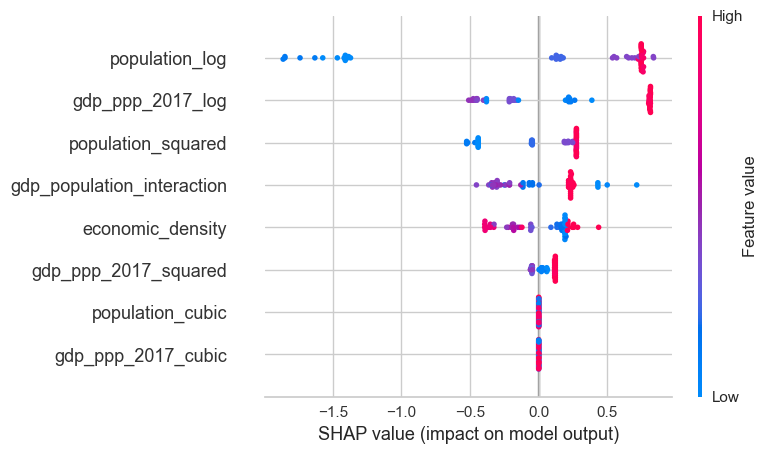

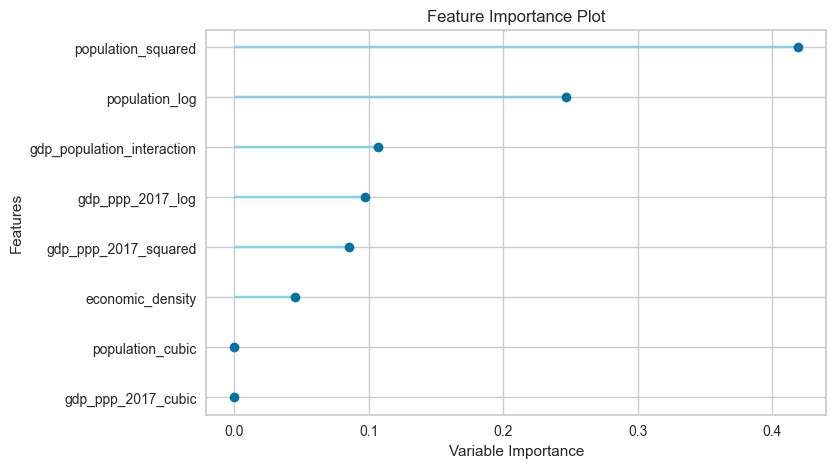


------------------------------
正在分析模型: CATBOOST
------------------------------


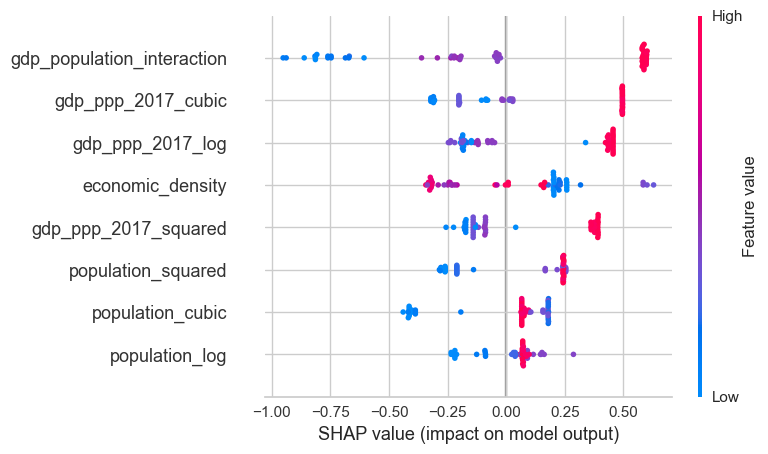

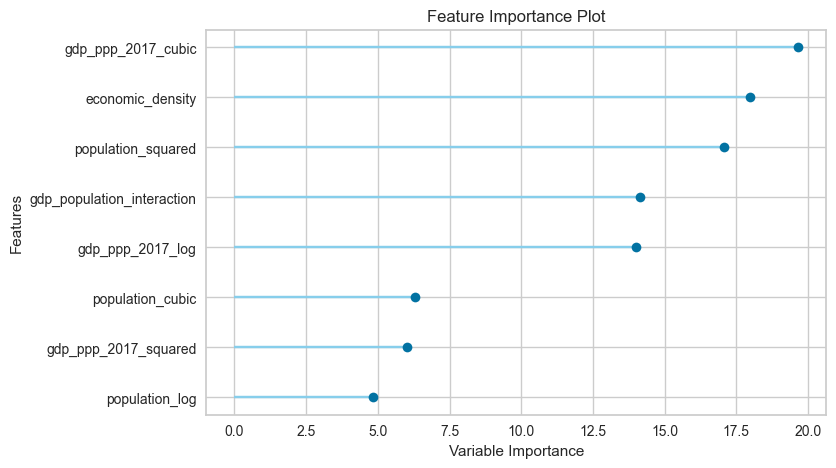


------------------------------
正在分析模型: GBR
------------------------------
gbr 不支持SHAP分析

------------------------------
正在分析模型: RF
------------------------------


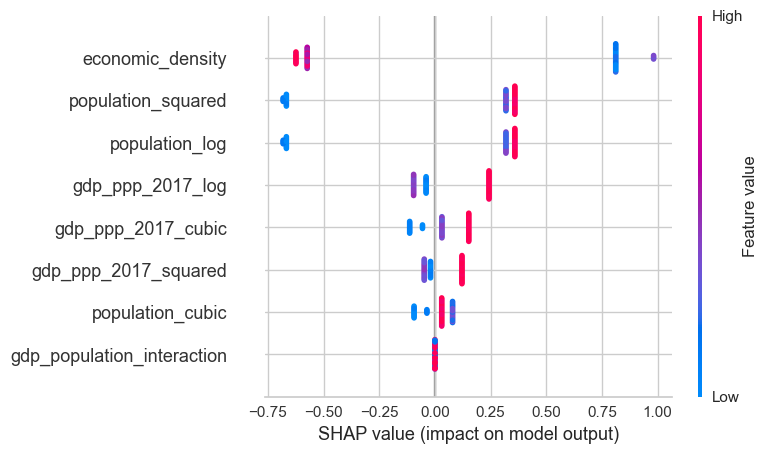

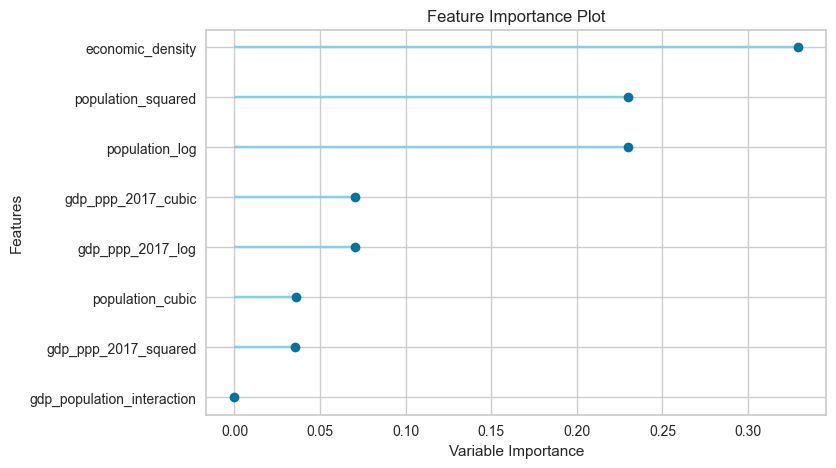


------------------------------
正在分析模型: ET
------------------------------


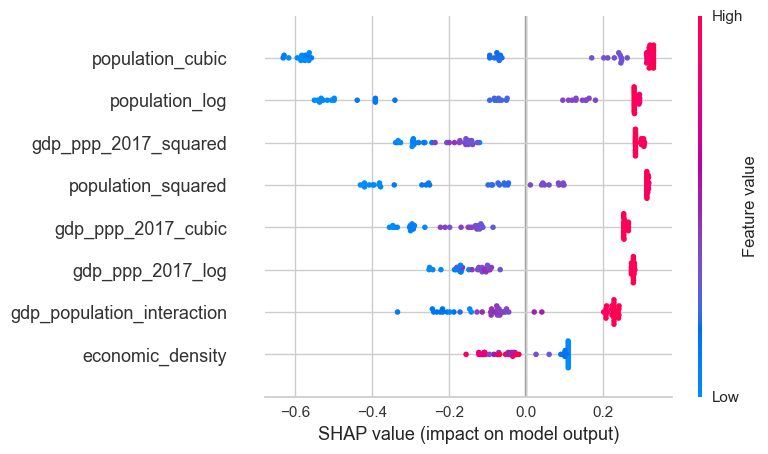

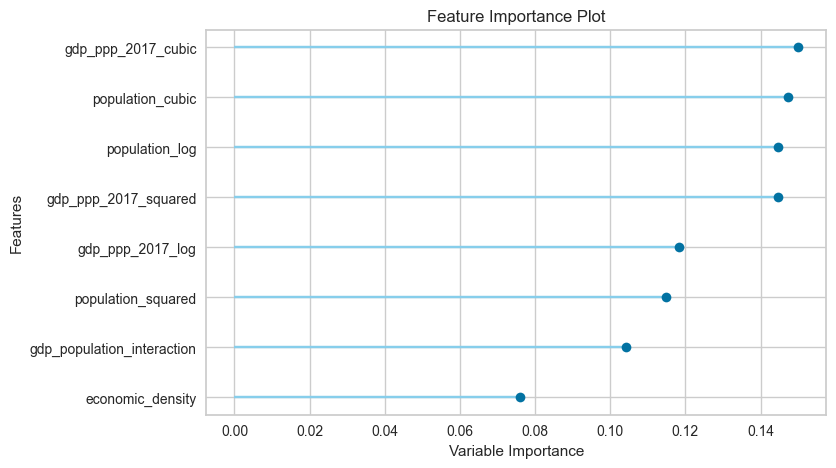


------------------------------
正在分析模型: LIGHTGBM
------------------------------


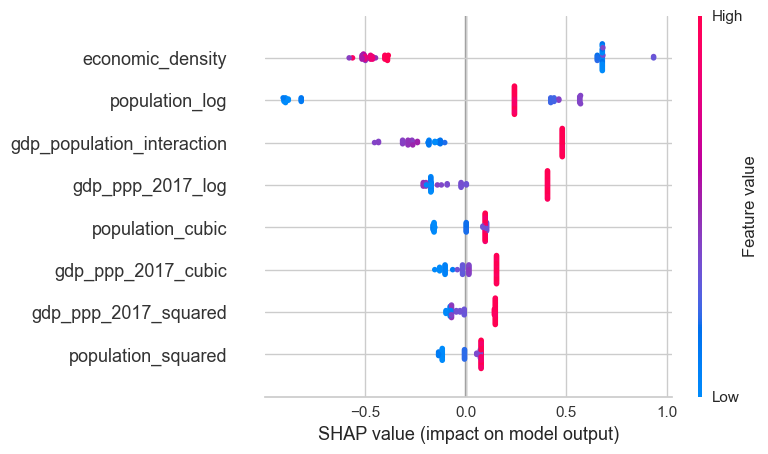

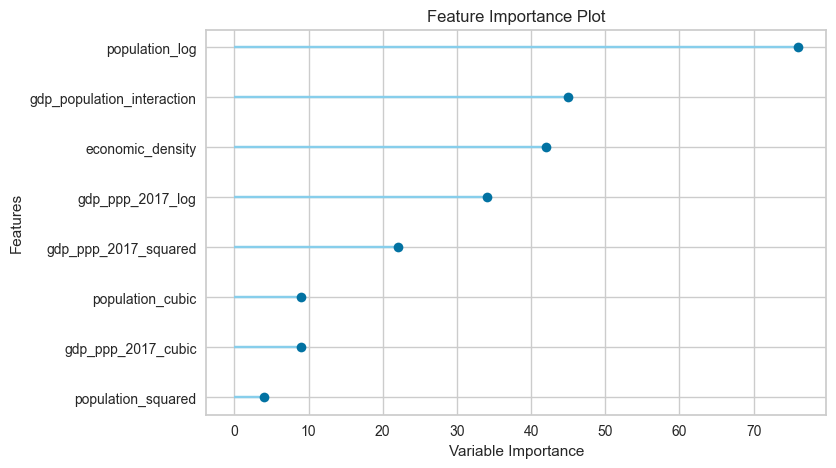


------------------------------
正在分析模型: BLEND
------------------------------
blend 不支持SHAP分析


In [8]:
for model_name, model in models.items():
    print(f"\n{'-'*30}")
    print(f"正在分析模型: {model_name.upper()}")
    print(f"{'-'*30}")
    
    # SHAP值解释（需要安装shap包）
    try:
        interpret_model(model)
        plot_model(model, plot = 'feature')
    except:
        print(f"{model_name} 不支持SHAP分析")

In [11]:
# 定义需要包含的模型简称集合
include_models = {'xgboost','rf','et'}

# 生成过滤后的有序字典
seleced_model_dict = {
    k: v for k, v in models.items()
    if k in include_models
}
# 集成
seleced_models = ensemble(seleced_model_dict)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8113,1.3793,1.1744,0.3847,0.0736,0.0530
1,1.6535,4.0815,2.0203,-1.3009,0.1327,0.1131
2,0.5657,0.4327,0.6578,0.8897,0.0485,0.0430
3,1.0953,2.2535,1.5012,0.5187,0.1126,0.0887
4,0.8164,0.9561,0.9778,0.8525,0.0688,0.0604
Mean,0.9884,1.8206,1.2663,0.2689,0.0872,0.0716
Std,0.3724,1.2781,0.4660,0.8082,0.0308,0.0257


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Extreme Gradient Boosting,0.9480,1.7256,1.2401,0.2876,0.0843,0.0679,0.0120
3,Voting Regressor,0.9884,1.8206,1.2663,0.2689,0.0872,0.0716,0.0380
1,Random Forest Regressor,1.0959,1.9133,1.3202,0.2581,0.0893,0.0778,0.0180
2,Extra Trees Regressor,1.0345,2.3838,1.4505,0.1242,0.1004,0.0769,0.0300


In [12]:
save_model = save_models(seleced_models)

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
